**Signature Forgery Detection using LoG, ResNet18 and Random Forest**

This project presents a hybrid feature-based approach to offline handwritten signature verification. It combines handcrafted and deep learning features to train a Random Forest (RF) classifier that distinguishes between  genuine and forged signatures of the same signer.

🔍 Features

Feature Extraction:

LoG (Laplacian of Gaussian): Captures edge and stroke-level details.
ResNet18 (Pretrained): Extracts deep semantic representations from grayscale signature images.
Feature Fusion: Concatenation of LoG and ResNet18 features.
Random Forest Classifier + Fusion of Similarity metric 

In [35]:
'''THIS SEGMENT IMPORT ALL NECESSARY LIBRARIES'''
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import random
from xgboost import XGBClassifier


In [2]:

'''THIS LOADS DATASET '''
# Define paths and parameters
path = "/Users/mac/Desktop/hy/ade/SignBank2"
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()


'''THIS DEFINES PATH AND DIRECTORY AND SEGREGATE THE GENUINE FROM FORGERY'''
# For each person segregate the genuine signatures from the forged signatures
orig_groups = []
forg_groups = []
for directory in dir_list:
    images = os.listdir(path + '/' + directory + '/')
    images.sort()
    for img in images:
        image_path = path + '/' + directory + '/' + img
        if img.startswith("orig"):
            orig_groups.append((image_path, 0))  # Label 0 for genuine
        else:
            forg_groups.append((image_path, 1))  # Label 1 for forged

print(f'lenght of Original images in dataset : {len(orig_groups)}') #display number of original signature images
print(f'lenght of fake images in dataset : {len(forg_groups)}')#displays no of forgery images


lenght of Original images in dataset : 340
lenght of fake images in dataset : 350


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warnin

The length of the entire preprocessed dataset: 690
The length of the preprocessed forgery: 350
The length of the preprocessed genuine: 340
The length of the entire unprocessed dataset: 690


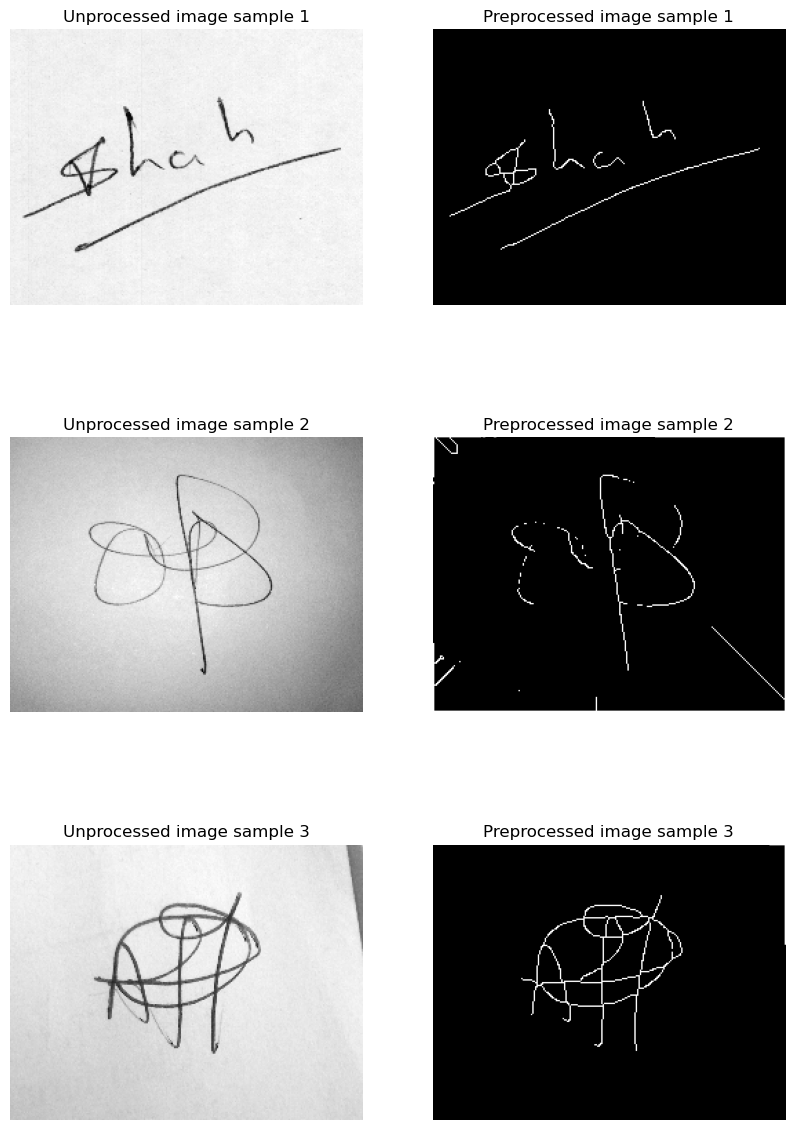

In [11]:

'''THIS SEGMENT PRE-PROCESSES IMAGES IN DATASET AND RANDOMLY DISPLAY 3 OF IT'''
# Preprocess images
unprocessed_odataset = []
unprocessed_fdataset = [] 
process_orig = []
process_forg = []
# Select random images for display
random_indices = random.sample(range(len(orig_groups)), 3)

for idx, (image_path, label) in enumerate(orig_groups):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256, 200))
    unprocessed_odataset.append(img_resized)
    img1 = cv2.GaussianBlur(img_resized, (5, 5), 0)  # Remove noise
    img1 = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  # Thresholding
    img1 = cv2.ximgproc.thinning(img1, None, cv2.ximgproc.THINNING_ZHANGSUEN)  # Thinning
    process_orig.append(img1)

for idx, (image_path, label) in enumerate(forg_groups):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256, 200))
    unprocessed_fdataset.append(img_resized)
    img1 = cv2.GaussianBlur(img_resized, (5, 5), 0)  # Remove noise
    img1 = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  # Thresholding
    img1 = cv2.ximgproc.thinning(img1, None, cv2.ximgproc.THINNING_ZHANGSUEN)  # Thinning
    process_forg.append(img1)

preprocessed_dataset = process_forg + process_orig
unprocessed_all = unprocessed_odataset + unprocessed_fdataset

print(f"The length of the entire preprocessed dataset: {len(preprocessed_dataset)}")
print(f"The length of the preprocessed forgery: {len(process_forg)}")
print(f"The length of the preprocessed genuine: {len(process_orig)}")
print(f"The length of the entire unprocessed dataset: {len(unprocessed_all)}")

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for j, idx in enumerate(random_indices):
    ax1, ax2 = axs[j]
    ax1.imshow(unprocessed_odataset[idx], cmap='gray')
    ax2.imshow(process_orig[idx], cmap='gray')
    ax1.set_title(f'Unprocessed image sample {j+1}')
    ax1.axis('off')
    ax2.set_title(f'Preprocessed image sample {j+1}')
    ax2.axis('off')

plt.show()


In [13]:
  '''FINE GRAINED LEVEL FEATURES IS BEEN EXTRACTED USING THE LOG'''

# Extract LoG features
def extract_log_features(img):
    log = cv2.GaussianBlur(img, (5, 5), 0)
    log = cv2.Laplacian(log, cv2.CV_8U)
    mean = np.mean(log)
    std = np.std(log)
    skewness = skew(log.ravel())
    return [mean, std, skewness]



orig_log_features = [extract_log_features(img) for img in process_orig]
forg_log_features = [extract_log_features(img) for img in process_forg]

print(f"Number of features extracted by  LoG: {len(orig_log_features[0])}")
print(f"Number of features extracted by LoG from forged images:  {len(forg_log_features[0])}")

Number of features extracted by  LoG: 3
Number of features extracted by LoG from forged images:  3


In [14]:
 '''HIGH LEVEL FEATURE EXTRACTION BY EMPLOYING THE RESNET'''
# Extract deep features using a pre-trained CNN
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.model = nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            x = self.model(x)
        return x

def extract_deep_features(img, model, transform):
    img = Image.fromarray(img)
    img = img.convert("RGB")
    img = transform(img).unsqueeze(0)
    features = model(img)
    return features.flatten().numpy()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = FeatureExtractor()
model.eval()

orig_deep_features = [extract_deep_features(img, model, transform) for img in process_orig]
forg_deep_features = [extract_deep_features(img, model, transform) for img in process_forg]


print(f"Number of features extracted by Deep from genuine images: {len(orig_deep_features[0])}")

print(f"Number of features extracted by Deep from forged images:  {len(forg_deep_features[0])}")

Number of features extracted by Deep from genuine images: 512
Number of features extracted by Deep from forged images:  512


In [81]:
 '''THIS COMBINES FEATURES EXTRACTED BY LOG AND RESNET AND DISPLAYS THE VALUE'''
# Combine HOG, LoG, and deep features
X = []
y = []
paths = []

# Genuine
for (log_feat, deep_feat), (path, label) in zip(zip(orig_log_features, orig_deep_features), orig_groups):
    X.append(np.concatenate((log_feat, deep_feat)))
    y.append(label)
    paths.append(path)

# Forgery
for (log_feat, deep_feat), (path, label) in zip(zip(forg_log_features, forg_deep_features), forg_groups):
    X.append(np.concatenate((log_feat, deep_feat)))
    y.append(label)
    paths.append(path)

X = np.array(X)
y = np.array(y)
paths = np.array(paths)

print(f"Number of features extracted by  LoG + Deep for (genuine): {len(orig_features[0])}")
print(f"Number of features extracted by LoG + Deep for (forgery): {len(forg_features[0])}")

Number of features extracted by  LoG + Deep for (genuine): 515
Number of features extracted by LoG + Deep for (forgery): 515


In [83]:
  '''THIS SEGMENT COMBINES THE THE FEATURES OF THE ORIGINAL IMAGES WITH THE FORGED ONES '''
  '''SPLITING OF DATASET INTO TRAIN: 80% AND TEST SET 20%'''
# Prepare dataset for classifier

# Split into train and test sets
X_train, X_test, y_train, y_test, path_train, path_test = train_test_split(
    X, y, paths, test_size=0.2, random_state=42
)


print(f"Train set - Original images: {len(y_train[y_train == 0])}, Forgery images: {len(y_train[y_train == 1])}")
print(f"Test set - Original images: {len(y_test[y_test == 0])}, Forgery images: {len(y_test[y_test == 1])}")





Train set - Original images: 261, Forgery images: 291
Test set - Original images: 79, Forgery images: 59


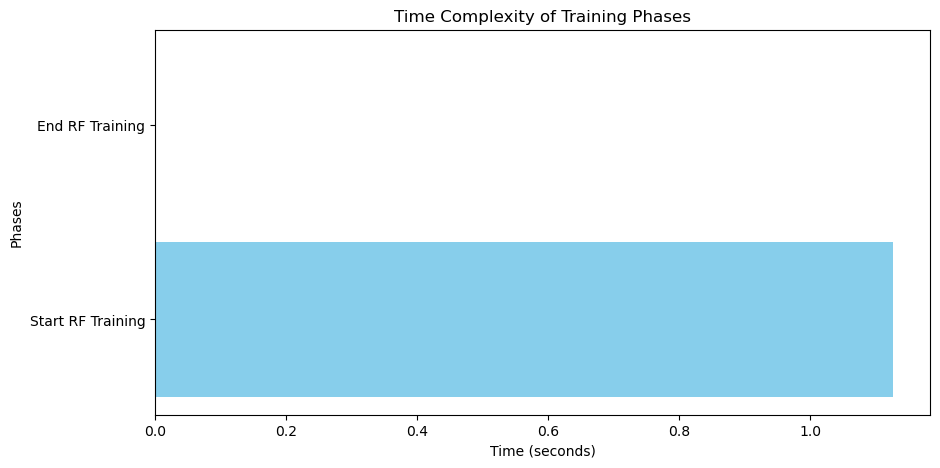

In [85]:
 '''THIS SEGMENT DEFINES AND TRAIN THE RF FOR CLASSIFICATION'''

import time
# Initialize lists to store time data
times = []
phases = []

# Function to track time and phase
def track_time(phase):
    current_time = time.time()
    times.append(current_time)
    phases.append(phase)

# start training time
track_time('Start RF Training')

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

track_time('End RF Training')
track_time('End')
#training ends

# Calculate time differences
time_diffs = [times[i + 1] - times[i] for i in range(len(times) - 1)]

# Plotting the time complexity
plt.figure(figsize=(10, 5))
plt.barh(phases[:-1], time_diffs, color='skyblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Phases')
plt.title('Time Complexity of Training Phases')
plt.show()


In [23]:
'''CROSS VALIDATION FOR RF'''
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=100, random_state=100)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.9057971  0.88405797 0.71014493 0.95652174 1.        ]
Average accuracy: 0.8913043478260869


RF Accuracy: 0.9565217391304348
RF Precision: 0.9649122807017544
RF Recall: 0.9322033898305084
RF F1 score: 0.9482758620689655
RF False Acceptance Rate (FAR): 0.02531645569620253
RF False Rejection Rate (FRR): 0.06779661016949153


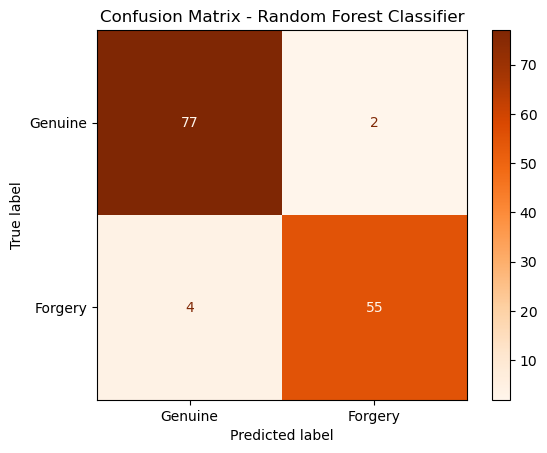

In [114]:
  '''THIS SEGMENT EVALUATES THE RF CLASSIFIER '''
# Evaluate the ResNet classifier
y_pred = clf.predict(X_test)
y_true = y_test  
rF_accuracy = accuracy_score(y_true, y_pred)
rF_precision = precision_score(y_true, y_pred)
rF_recall = recall_score(y_true, y_pred)
rF_f1 = f1_score(y_true, y_pred)
print(f"RF Accuracy: {rF_accuracy}")
print(f"RF Precision: {rF_precision}")
print(f"RF Recall: {rF_recall}")
print(f"RF F1 score: {rF_f1}")

# Calculate ResNet FAR and FRR
rF_false_accepts = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
rF_false_rejects = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
rF_total_genuine = np.sum(np.array(y_true) == 0)
rF_total_forged = np.sum(np.array(y_true) == 1)
rF_far = rF_false_accepts / rF_total_genuine
rF_frr = rF_false_rejects / rF_total_forged

print(f"RF False Acceptance Rate (FAR): {rF_far}")
print(f"RF False Rejection Rate (FRR): {rF_frr}")

#display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Forgery"])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

In [ ]:
#pip install xgboost

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier Metrics:
Accuracy: 0.9565
Precision: 0.9492
Recall: 0.9492
F1 Score: 0.9492
False Acceptance Rate (FAR): 0.0380
False Rejection Rate (FRR): 0.0508


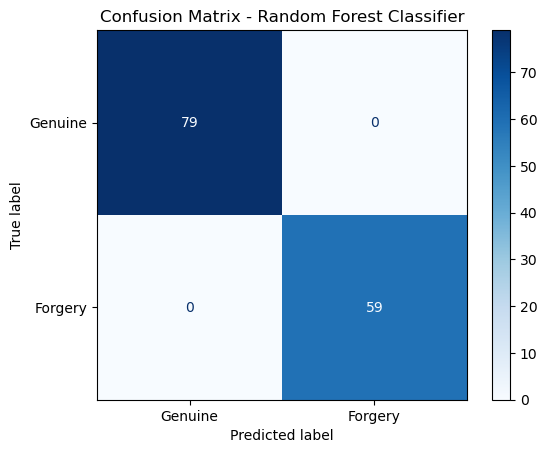

In [61]:
'''THIS SEGMENT TRAINS XGBOOST'''

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Prediction
xgb_pred = xgb_clf.predict(X_test)

y_true = y_test

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    false_accepts = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    false_rejects = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    total_genuine = np.sum(np.array(y_true) == 0)
    total_forged = np.sum(np.array(y_true) == 1)
    far = false_accepts / total_genuine
    frr = false_rejects / total_forged

    print(f"\n{name} Classifier Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Acceptance Rate (FAR): {far:.4f}")
    print(f"False Rejection Rate (FRR): {frr:.4f}")

evaluate_model("XGBoost", y_true, xgb_pred)

#Display Confusion Matrix
cm = confusion_matrix(y_true, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Forgery"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

Text(0.5, 1.0, 'Feature Importances')

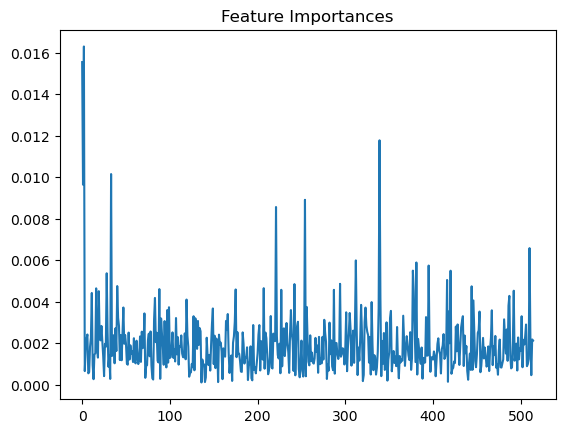

In [41]:
'''DISPLAY FEATURE IMPORTANCE'''
importances = clf.feature_importances_
plt.plot(importances)
plt.title("Feature Importances")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


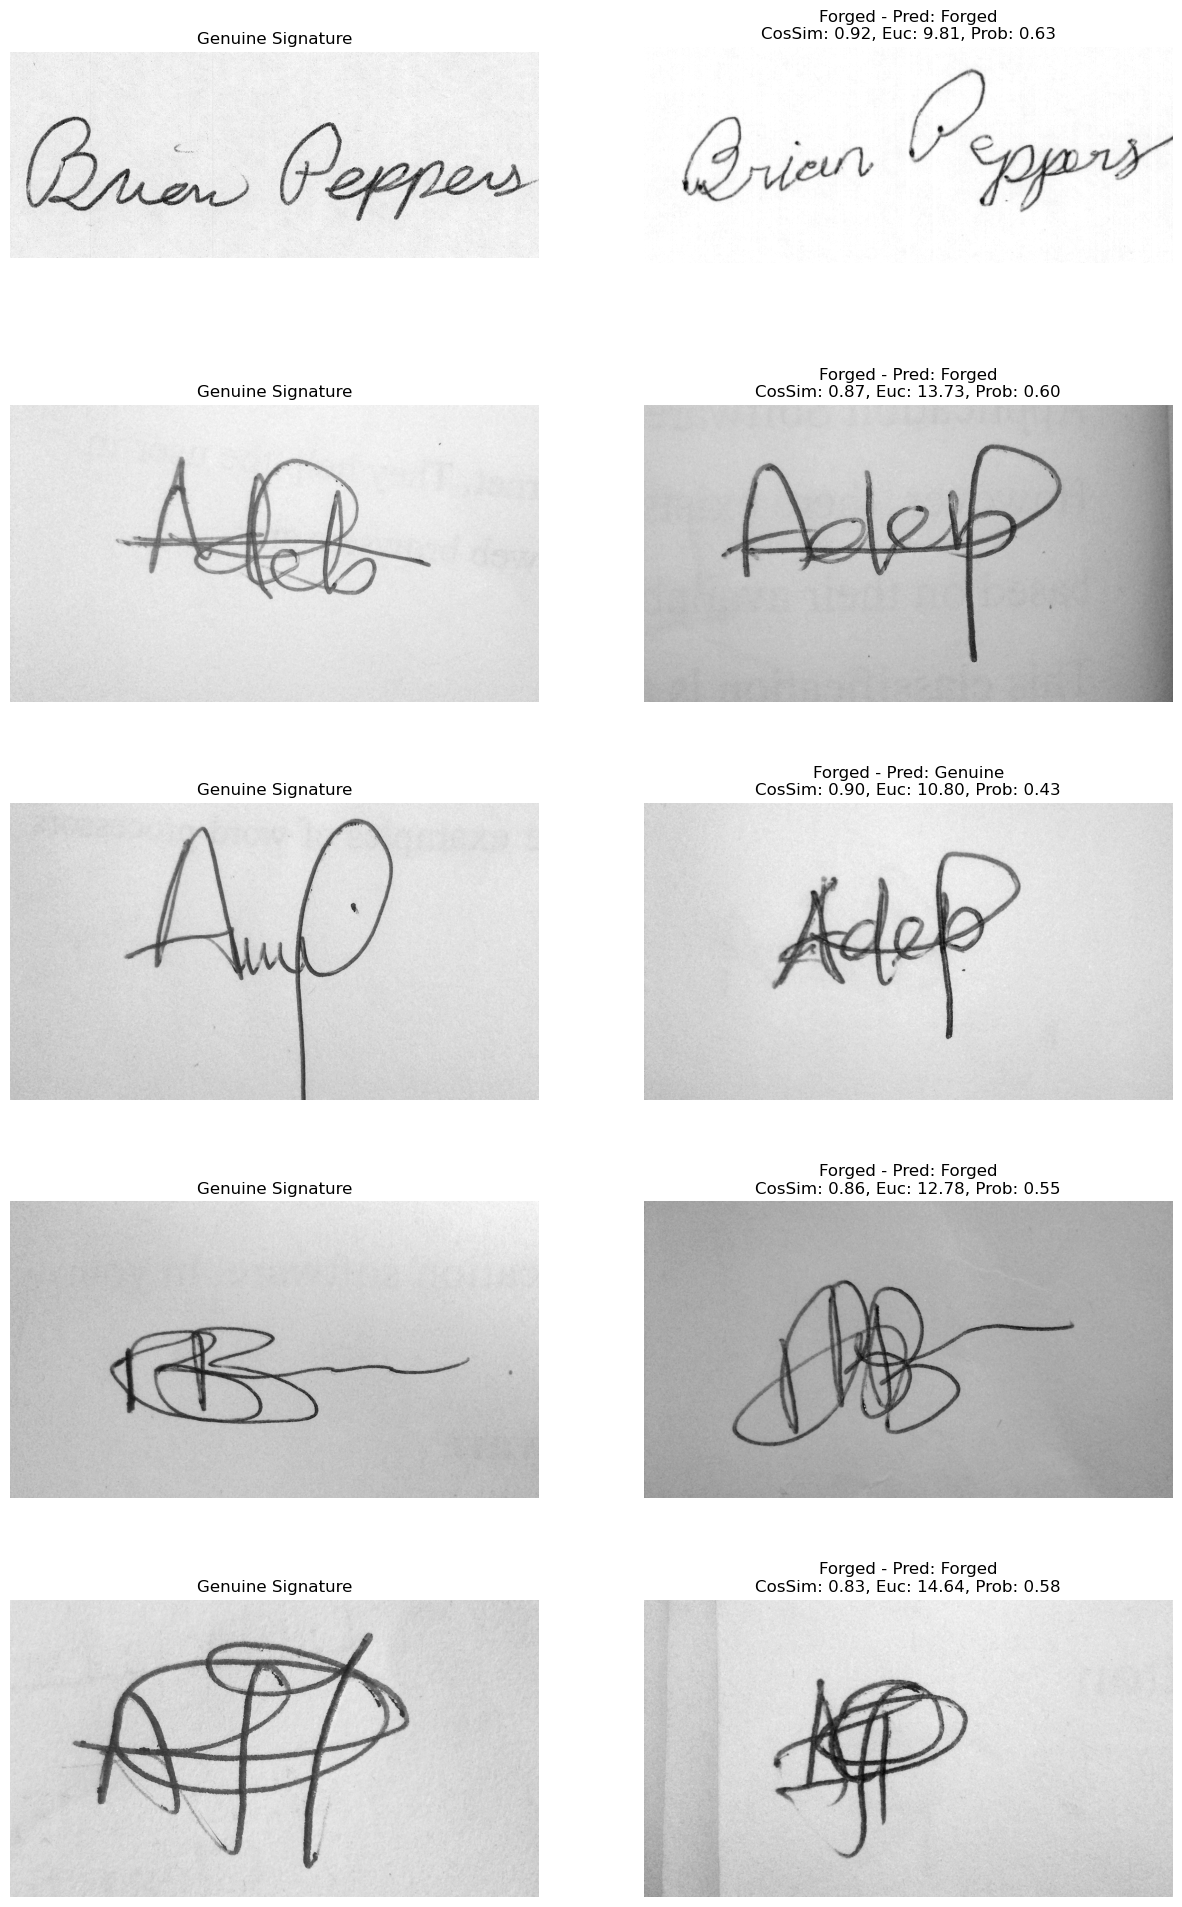

In [127]:
'''THIS SEGMENT FUSE SIMILARITY METRICS WITH RF CLASSIFIER SCORE FOR PREDICTION'''

# Group test samples by signer
signer_groups = {}
for idx, label in enumerate(y_test):
    signer_id = orig_groups[idx][0].split('_')[1]
    if signer_id not in signer_groups:
        signer_groups[signer_id] = {'orig': [], 'forg': []}
    if label == 0:
        signer_groups[signer_id]['orig'].append(idx)
    else:
        signer_groups[signer_id]['forg'].append(idx)

# Visualize predictions for 5 random signers
num_predictions = 5
random_signers = random.sample(list(signer_groups.keys()), num_predictions)
fig, axs = plt.subplots(num_predictions, 2, figsize=(15, 5 * num_predictions))

for j, signer_id in enumerate(random_signers):
    ax1, ax2 = axs[j]

    genuine_idx = random.choice(signer_groups[signer_id]['orig'])
    compare_label = "Forged" if signer_groups[signer_id]['forg'] else "Genuine"
    compare_idx = random.choice(signer_groups[signer_id]['forg'] if compare_label == "Forged" else signer_groups[signer_id]['orig'])

    # Load paths for display
    genuine_img_path = orig_groups[genuine_idx][0]
    compare_img_path = forg_groups[compare_idx][0] if compare_label == "Forged" else orig_groups[compare_idx][0]

    # display compared images
    ax1.imshow(cv2.imread(genuine_img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    ax1.set_title("Genuine Signature")
    ax1.axis('off')

    ax2.imshow(cv2.imread(compare_img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    ax2.axis('off')

    # using already extracted features
    feat1 = X_test[genuine_idx]
    feat2 = X_test[compare_idx]

    # Calculate similarity metric scores based on feature
    cos_sim = cosine_similarity([feat1], [feat2])[0][0]
    euc_dist = euclidean(feat1, feat2)

    # Predict
    pair_feature = np.abs(feat1 - feat2).reshape(1, -1)
    pred = clf.predict(pair_feature)[0]
    prob = clf.predict_proba(pair_feature)[0][1]  # Probability of being forged

    ax2.set_title(f'{compare_label} - Pred: {"Forged" if pred==1 else "Genuine"}\n'
                  f'CosSim: {cos_sim:.2f}, Euc: {euc_dist:.2f}, Prob: {prob:.2f}')


In [ ]:

#saving Random Forest model
import joblib

#joblib.dump(clf, 'random_forest_model.pkl')


